# Filtering rows 3: multiple filter conditions
By the end of this lecture you will be able to:
- use multiple AND conditions in `filter`
- use multiple OR conditions in `filter`
- optimise multiple conditions in lazy mode

In [1]:
import polars as pl

In [2]:
csv_file = "../data/titanic.csv"

In [3]:
df = pl.read_csv(csv_file)

## Multiple conditions

### Apply `AND` conditions

We can apply filter `AND` conditions where all conditions must be met in a number of ways.

The first way is to **chaining** multiple calls to `filter`.

In this example we keep all first class passengers that are over 70

In [4]:
(
    df
    .filter(
        Pclass = 1
    )
    .filter(
        pl.col('Age') > 70
    )
    .head(3)
)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
97,0,1,"""Goldschmidt, Mr. George B""","""male""",71.0,0,0,"""PC 17754""",34.6542,"""A5""","""C"""
494,0,1,"""Artagaveytia, Mr. Ramon""","""male""",71.0,0,0,"""PC 17609""",49.5042,null,"""C"""
631,1,1,"""Barkworth, Mr. Algernon Henry …","""male""",80.0,0,0,"""27042""",30.0,"""A23""","""S"""


In [6]:
# pclass 가 1이면서 나이가 70세 이상 고객 데이터
(
    df
    .filter(
        (pl.col('Pclass') == 1) & (pl.col('Age') > 70)
    )
    .head(3)
)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
97,0,1,"""Goldschmidt, Mr. George B""","""male""",71.0,0,0,"""PC 17754""",34.6542,"""A5""","""C"""
494,0,1,"""Artagaveytia, Mr. Ramon""","""male""",71.0,0,0,"""PC 17609""",49.5042,null,"""C"""
631,1,1,"""Barkworth, Mr. Algernon Henry …","""male""",80.0,0,0,"""27042""",30.0,"""A23""","""S"""


In eager mode chaining is inefficient. For each call to `filter` Polars has to do a full pass through the rows of the `DataFrame`. It is better to combine everything into a single condition 

One way to do this is to **concatenate** multiple `AND` conditions in a single `filter` call using `&`

In [ ]:
(
    df
    .filter(
        (pl.col('Age') > 70) & (pl.col('Pclass') == 1)
    )
    .head(2)
)

There is a less verbose way to do this by passing the predicates as a comma-separated list of expressions

In [ ]:
(
    df
    .filter(
        pl.col("Pclass") == 1,
        pl.col("Age") > 70
    )
    .head(2)
)

If we are applying multiple *equality* conditions we can do this with keywords (note the single `=` in this format)

In [ ]:
(
    df
    .filter(
        Pclass = 1,
        Age = 70
    )
)

### Apply an AND condition using `pl.all_horizontal`
Specifying multiple conditions in chained `filters` or using `&` is fine when we have a small number of conditions to apply. However, we can use the `pl.all_horizontal` method when we want to apply an AND condition on many columns.

> The methods above with a comma-separate list of conditions are equivalent to `pl.all_horizontal`

In this example we:
- first call `pl.all().is_not_null()` to create a Boolean `DataFrame` where each call is True if the underlying value is not `null`
- then call `pl.all_horizontal` to find rows where all values are `True` (i.e. all values are not `null`)

In [7]:
(
    df
    .filter(
        pl.all_horizontal(
            pl.all().is_not_null()
        )
    )
    .head(2)
)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
4,1,1,"""Futrelle, Mrs. Jacques Heath (…","""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""


* 보통, 여러 열에 대해 각각 조건을 걸 때는 & 연산자를 사용하지만, 조건이 많아질 경우 이를 관리하기 어려워질 수 있습니다. 이때 pl.all_horizontal을 사용하면 여러 열에 걸친 모든 조건이 동시에 참인지 간단하게 확인할 수 있습니다.

In [12]:
(
    df
    .filter(
        pl.all_horizontal(
            pl.col('Age') > 60,
            pl.col('Pclass') == 1,
            pl.col('Sex') == 'female',
            pl.col('Survived') == 1
        )
    )
)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
276,1,1,"""Andrews, Miss. Kornelia Theodo…","""female""",63.0,1,0,"""13502""",77.9583,"""D7""","""S"""
830,1,1,"""Stone, Mrs. George Nelson (Mar…","""female""",62.0,0,0,"""113572""",80.0,"""B28""",null


### Apply `AND` condition on a range

We use `in_between` to apply a condition on a range. In this case we are looking for values **greater than or equal to** 10 and **less than or equal to** 13

In [13]:
(
    df
    .filter(
        pl.col("Age").is_between(10,13)
    )
    .head(2)
)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
60,0,3,"""Goodwin, Master. William Frede…","""male""",11.0,5,2,"""CA 2144""",46.9,null,"""S"""
126,1,3,"""Nicola-Yarred, Master. Elias""","""male""",12.0,1,0,"""2651""",11.2417,null,"""C"""


In [14]:
(
    df
    .filter(
        (pl.col('Age') > 10) & (pl.col('Age') < 13)
    )
    .head(2)
)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
60,0,3,"""Goodwin, Master. William Frede…","""male""",11.0,5,2,"""CA 2144""",46.9,null,"""S"""
126,1,3,"""Nicola-Yarred, Master. Elias""","""male""",12.0,1,0,"""2651""",11.2417,null,"""C"""


In [16]:
(
    df
    .filter(
        pl.all_horizontal(
            pl.col("Age") > 10,
            pl.col("Age") < 13
        )
    )
    .head(2)
)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
60,0,3,"""Goodwin, Master. William Frede…","""male""",11.0,5,2,"""CA 2144""",46.9,null,"""S"""
126,1,3,"""Nicola-Yarred, Master. Elias""","""male""",12.0,1,0,"""2651""",11.2417,null,"""C"""


We use the `closed` argument to specify if we want the range to be open, closed on both sides or open on the left or right. The default is for the range to be closed (with a value of `"both"`). 

In this example we are looking for values from 10 to 13 exclusive of the boundaries

In [ ]:
(
    df
    .filter(
        pl.col("Age").is_between(10,13,closed="none")
    )
    .head(2)
)

### Apply `OR` conditions

We can apply an OR filter using the pipe `|` operator.

In this example we look for rows where the passenger is over 70 OR the passenger is in first class

In [ ]:
(
    df
    .filter(
        (pl.col('Age') > 70) | (pl.col('Pclass') == 1)
    )
    .head(2)
)

One kind of OR condition is when we want to check if a row is equal to any value in a `list`. We can do this with `is_in`

In [26]:
(
    df
    .filter(
        pl.col('Pclass').is_in([2,3])
    )
)['Pclass'].to_list().__contains__(1)

False

In [30]:
(
    df
    .filter(
        pl.col("Name").is_in(["Heikkinen, Miss. Laina"])
    )
)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S"""


### Multiple conditions in lazy mode
In *lazy mode* if we pass multiple `filter` calls then the query optimizer combines these into a *single condition* inside `SELECTION`.

In this example we filter for first class passengers over the age of 70.

In [31]:
df = (
    pl.scan_csv(csv_file)
    .filter(
        pl.col('Pclass')==1
    )
    .filter(
        (pl.col('Age') > 70)
    )
)
print(df.explain())

Csv SCAN [../data/titanic.csv]
PROJECT */12 COLUMNS
SELECTION: [([(col("Age")) > (70.0)]) & ([(col("Pclass")) == (1)])]


In the query plan we see the conditionsa are combined to a single condition by the query optimiser

## Exercises
In the exercises you will develop your understanding of:
- applying multiple AND conditions
- applying multiple OR conditions

### Exercise 1 
Filter the `DataFrame` to find rows where `Age` is between 30 and 50 (including the lower bound) and the passenger is in 2nd class. Do this in eager mode in a single pass through the `DataFrame`

In [32]:
(
    pl.read_csv(csv_file)
    .filter(
        pl.all_horizontal(
            pl.col("Age").is_between(30, 50),
            pl.col("Pclass") == 2
        )
    )
    .head()
)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
21,0,2,"""Fynney, Mr. Joseph J""","""male""",35.0,0,0,"""239865""",26.0,null,"""S"""
22,1,2,"""Beesley, Mr. Lawrence""","""male""",34.0,0,0,"""248698""",13.0,"""D56""","""S"""
71,0,2,"""Jenkin, Mr. Stephen Curnow""","""male""",32.0,0,0,"""C.A. 33111""",10.5,null,"""S"""
99,1,2,"""Doling, Mrs. John T (Ada Julia…","""female""",34.0,0,1,"""231919""",23.0,null,"""S"""
100,0,2,"""Kantor, Mr. Sinai""","""male""",34.0,1,0,"""244367""",26.0,null,"""S"""


Do this again combining the range condition with the keyword approach for the 2nd class condition - does the order you pass the conditions matter?

### Exercise 2
Return all the rows of the `DataFrame` where at least one column on the row is `null` (excluding the `Cabin` column with many `null` values)

* pl.any_horizontal: 특정 행의 여러 열에서 조건 중 하나라도 참(True)이면 그 행을 선택합니다.

* `horizontal`: 특정 행(관측치)을 잡고 그 행의 컬럼 조건 통과 여부를 보는 것임.

In [35]:
(
    pl.read_csv(csv_file)
    .drop("Cabin")
    .filter(
        pl.any_horizontal(
            pl.all().is_null()
        )
    )
    .head()
)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str
6,0,3,"""Moran, Mr. James""","""male""",null,0,0,"""330877""",8.4583,"""Q"""
18,1,2,"""Williams, Mr. Charles Eugene""","""male""",null,0,0,"""244373""",13.0,"""S"""
20,1,3,"""Masselmani, Mrs. Fatima""","""female""",null,0,0,"""2649""",7.225,"""C"""
27,0,3,"""Emir, Mr. Farred Chehab""","""male""",null,0,0,"""2631""",7.225,"""C"""
29,1,3,"""O'Dwyer, Miss. Ellen ""Nellie""""","""female""",null,0,0,"""330959""",7.8792,"""Q"""


### Exercise 3
Create a `DataFrame` where the passengers got on in Cork ("C") or Southampton ("S") using the pipe operator

In [36]:
(
    pl.read_csv(csv_file)
    .filter(
        (pl.col("Embarked") == "C") | (pl.col("Embarked") == "S")
    )
    .head()
)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S"""
4,1,1,"""Futrelle, Mrs. Jacques Heath (…","""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""
5,0,3,"""Allen, Mr. William Henry""","""male""",35.0,0,0,"""373450""",8.05,null,"""S"""


Do this again using the `is_in` approach

In [37]:
(
    pl.read_csv(csv_file)
    .filter(
        pl.col("Embarked").is_in(['C', 'S'])
    )
    .head()
)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S"""
4,1,1,"""Futrelle, Mrs. Jacques Heath (…","""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""
5,0,3,"""Allen, Mr. William Henry""","""male""",35.0,0,0,"""373450""",8.05,null,"""S"""


### Exercise 4
Load the Spotify CSV data into a `DataFrame`

In [41]:
pl.Config.set_fmt_str_lengths(30)
spotify_csv = "../data/spotify-charts-2017-2021-global-top200.csv.gz"
spotify_df = pl.read_csv(spotify_csv)
spotify_df.head()

title,rank,date,artist,url,region,chart,trend,streams
str,i64,str,str,str,str,str,str,i64
"""Starboy""",1,"""2017-01-01""","""The Weeknd, Daft Punk""","""https://open.spotify.com/track…","""Global""","""top200""","""SAME_POSITION""",3135625
"""Closer""",2,"""2017-01-01""","""The Chainsmokers, Halsey""","""https://open.spotify.com/track…","""Global""","""top200""","""SAME_POSITION""",3015525
"""Let Me Love You""",3,"""2017-01-01""","""DJ Snake, Justin Bieber""","""https://open.spotify.com/track…","""Global""","""top200""","""MOVE_UP""",2545384
"""Rockabye (feat. Sean Paul & An…",4,"""2017-01-01""","""Clean Bandit""","""https://open.spotify.com/track…","""Global""","""top200""","""MOVE_DOWN""",2356604
"""One Dance""",5,"""2017-01-01""","""Drake, WizKid, Kyla""","""https://open.spotify.com/track…","""Global""","""top200""","""SAME_POSITION""",2259887


Find all rows where the number of streams is greater than 10 million and the trend is "NEW_ENTRY"  

In [49]:
(
    spotify_df
    .filter(
        pl.all_horizontal(
            pl.col('streams') > 10_000_000,
            pl.col('trend') == 'NEW_ENTRY'
        )
    )
    .head()
)

title,rank,date,artist,url,region,chart,trend,streams
str,i64,str,str,str,str,str,str,i64
"""I Don't Care (with Justin Bieb…",1,"""2019-05-10""","""Ed Sheeran""","""https://open.spotify.com/track…","""Global""","""top200""","""NEW_ENTRY""",10977389
"""Butter""",2,"""2021-05-21""","""BTS""","""https://open.spotify.com/track…","""Global""","""top200""","""NEW_ENTRY""",11042335
"""Girls Want Girls (with Lil Bab…",1,"""2021-09-03""","""Drake""","""https://open.spotify.com/track…","""Global""","""top200""","""NEW_ENTRY""",12384750
"""Champagne Poetry""",2,"""2021-09-03""","""Drake""","""https://open.spotify.com/track…","""Global""","""top200""","""NEW_ENTRY""",11696783
"""Fair Trade (with Travis Scott)""",3,"""2021-09-03""","""Drake""","""https://open.spotify.com/track…","""Global""","""top200""","""NEW_ENTRY""",11642541


Find the rows where the artist is either Drake or Ed Sheeran and the rank is less than (better than) 5

In [87]:
(
    spotify_df
    .filter(
        pl.col('artist').is_in(['Drake', 'Ed Sheeran'])
    )
    .filter(
        pl.col('rank') < 5
    )
).select('title', 'artist').unique().sort(by = 'title').group_by('artist').len()

artist,len
str,u32
"""Drake""",20
"""Ed Sheeran""",9


Text(0, 0.5, '탑5횟수')

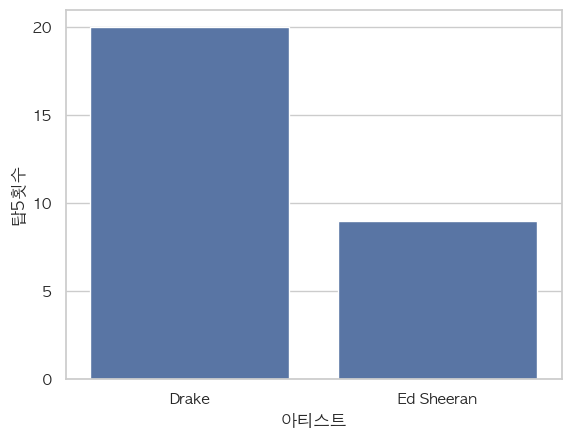

In [100]:
tmp=(
    spotify_df
    .filter(
        (pl.col('artist').is_in(['Drake', 'Ed Sheeran'])) & (pl.col('rank') < 5)
    )
    .select('title', 'artist')
    .unique()
    .group_by('artist')
    .agg(pl.count('title').alias('unique_titles'))
    .sort('artist')
)

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style = 'whitegrid')
plt.rcParams['font.family'] = 'AppleGothic'
sns.barplot(data = tmp, x = 'artist', y = 'unique_titles')
plt.yticks(ticks=[0, 5, 10, 15, 20], labels=['0', '5', '10', '15', '20'])
plt.xlabel('아티스트')
plt.ylabel('탑5횟수')


## Solutions
### Solution to Exercise 1
Create a `DataFrame` where `Age` is between 30 and 50 (including the lower bound) and the passenger is in 2nd class. Do this in eager mode in a single pass through the `DataFrame`

In [ ]:
(
    pl.read_csv(csv_file)
    .filter(
        (pl.col('Age').is_between(30,50,closed="left")) & (pl.col('Pclass')==2)
    )
    .head()
)

Do this again combining the range condition with the keyword approach for the 2nd class condition - does the order you pass the conditions matter?

In [ ]:
(
    pl.read_csv(csv_file)
    .filter(
        pl.col('Age').is_between(30,50,closed="left"),
        Pclass=2,
    )
    .head()
)

The order you do this matters - Python keyword arguments must be the last on the list

### Solution to Exercise 2
Return all the rows of the `DataFrame` where at least one column on the row is `null` (excluding the `Cabin` column with many `null` values)

In [ ]:
(
    pl.read_csv(csv_file)
    .drop("Cabin")
    .filter(
        pl.any_horizontal(
            pl.all().is_null()
        )
    )
    .head()
)

### Solution to Exercise 3
Create a `DataFrame` where the passengers got on in Cork ("C") or Southampton ("S") using the pipe operator

In [ ]:
(
    pl.read_csv(csv_file)
    .filter(
        (pl.col('Embarked') == "C") | (pl.col('Embarked') == "S")
    )
    .head(3)
)

Do this again using the `is_in` approach

In [ ]:
(
    pl.read_csv(csv_file)
    .filter(
        pl.col('Embarked').is_in(["C","S"])
    )
    .head()
)

### Solution to Exercise 4
Load the Spotify CSV data into a `DataFrame`

In [ ]:
pl.Config.set_fmt_str_lengths(30)
spotify_csv = "../data/spotify-charts-2017-2021-global-top200.csv.gz"
spotify_df = pl.read_csv(spotify_csv)
spotify_df.head()

Find all rows where the number of streams is greater than 10 million and the trend is "NEW_ENTRY"  

In [ ]:
(
    spotify_df
    .filter(
        pl.col("streams")>1e7,
        trend = "NEW_ENTRY"
    )
)

Find the rows where the artist is either Drake or Ed Sheeran and the rank is less than (better than) 5

In [52]:
(
    spotify_df
    .filter(
        pl.col("artist").is_in(["Drake","Ed Sheeran"])
    )
    .filter(pl.col("rank")<5)
)

title,rank,date,artist,url,region,chart,trend,streams
str,i64,str,str,str,str,str,str,i64
"""God's Plan""",1,"""2018-03-01""","""Drake""","""https://open.spotify.com/track…","""Global""","""top200""","""SAME_POSITION""",7572795
"""Shape of You""",1,"""2017-02-01""","""Ed Sheeran""","""https://open.spotify.com/track…","""Global""","""top200""","""SAME_POSITION""",7549041
"""God's Plan""",1,"""2018-03-02""","""Drake""","""https://open.spotify.com/track…","""Global""","""top200""","""SAME_POSITION""",7817732
"""Shape of You""",1,"""2017-02-02""","""Ed Sheeran""","""https://open.spotify.com/track…","""Global""","""top200""","""SAME_POSITION""",7602214
"""Shape of You""",1,"""2017-02-03""","""Ed Sheeran""","""https://open.spotify.com/track…","""Global""","""top200""","""SAME_POSITION""",7881255
…,…,…,…,…,…,…,…,…
"""Shivers""",4,"""2021-10-30""","""Ed Sheeran""","""https://open.spotify.com/track…","""Global""","""top200""","""SAME_POSITION""",4995236
"""Shivers""",4,"""2021-10-31""","""Ed Sheeran""","""https://open.spotify.com/track…","""Global""","""top200""","""SAME_POSITION""",4195481
"""God's Plan""",1,"""2018-01-29""","""Drake""","""https://open.spotify.com/track…","""Global""","""top200""","""SAME_POSITION""",7272380
